In [1]:
import os
import sys



os.environ["MOMAPS_HOME"] = "/home/labs/hornsteinlab/Collaboration/MOmaps"
sys.path.insert(1, os.getenv("MOMAPS_HOME"))
print(f"MOMAPS_HOME: {os.getenv('MOMAPS_HOME')}")

import numpy as np
import pandas as pd
import logging
import  torch
import datetime

from src.common.lib.utils import get_if_exists, load_config_file
from src.common.lib.model import Model

from src.common.lib.metrics import cluster_without_outliers

MOMAPS_HOME: /home/labs/hornsteinlab/Collaboration/MOmaps


/home/labs/hornsteinlab/sagyk/anaconda3/envs/cytoself_torch/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/labs/hornsteinlab/sagyk/anaconda3/envs/cytoself_torch/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/labs/hornsteinla

In [11]:
config_path_model = "./src/models/neuroself/configs/model_config/TLNeuroselfB78NoDSModelConfig" #sys.argv[1]
config_path_data = "./src/figures/figures_config/FigSup5ATestSmallConfig" #sys.argv[2]
output_folder_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy"

config_model = load_config_file(config_path_model, 'model')
config_data = load_config_file(config_path_data, 'data', config_model.CONFIGS_USED_FOLDER)
# figure_output_folder = get_if_exists(config_data, 'FIGURE_OUTPUT_FOLDER', None)
# if len(sys.argv) > 3:
#     output_folder_path = sys.argv[3]
# elif figure_output_folder is not None:
#     output_folder_path = figure_output_folder
# else:
#     output_folder_path = config_model.MODEL_OUTPUT_FOLDER

assert os.path.isdir(output_folder_path) and os.path.exists(output_folder_path), f"{output_folder_path} is an invalid output folder path or doesn't exists"

logging.info("init")
logging.info("[Generate UMAPs]")

logging.info(f"Is GPU available: {torch.cuda.is_available()}")
logging.info(f"Num GPUs Available: {torch.cuda.device_count()}")
    
__unique_labels_path = os.path.join(config_model.MODEL_OUTPUT_FOLDER, "unique_labels.npy")
if os.path.exists(__unique_labels_path):
    logging.info(f"unique_labels.npy files has been detected - using it. ({__unique_labels_path})")
    unique_markers = np.load(__unique_labels_path)
else:
    logging.warn(f"Couldn't find unique_labels file: {__unique_labels_path}")
    raise Exception(f"Couldn't find unique_labels file: {__unique_labels_path}")

logging.info("Init model")
model = Model(config_model)

logging.info(f"Loading model (Path: {config_model.MODEL_PATH})")
model.load_model(num_fc_output_classes=len(unique_markers))

logging.info("Clearing cache")
torch.cuda.empty_cache()


model.generate_dummy_analytics()
embeddings, labels = model.load_embeddings(embeddings_type='testset' if config_data.SPLIT_DATA else 'all',
                                            config_data=config_data)

markers = ["PURA"] #np.unique([m.split('_')[-1] if '_' in m else m for m in np.unique(labels.reshape(-1,))]) 
logging.info(f"Detected markers: {markers}")

c = markers[0]

logging.info(f"Marker: {c}")
logging.info(f"[{c}] Selecting indexes of marker")
c_indexes = np.where(np.char.endswith(labels.astype(str), f"_{c}"))[0]
logging.info(f"[{c}] {len(c_indexes)} indexes have been selected")

if len(c_indexes) == 0:
    logging.info(f"[{c}] Not exists in embedding. Skipping to the next one")

embeddings_c, labels_c = np.copy(embeddings[c_indexes]), np.copy(labels[c_indexes].reshape(-1,))
    
    

ModuleNotFoundError: No module named 'src.figures.figures_config'

In [ ]:

__now = datetime.datetime.now()

logging.info(f"[{c}] Plot umap...")
title = f"{'_'.join([os.path.basename(f) for f in config_data.INPUT_FOLDERS])}_{c}"
savepath = os.path.join(output_folder_path,\
                        'UMAPs',\
                            f'{__now.strftime("%d%m%y_%H%M%S_%f")}_{os.path.splitext(os.path.basename(config_model.MODEL_PATH))[0]}',\
                                f'{title}') # NANCY

__savepath_parent = os.path.dirname(savepath)
if not os.path.exists(__savepath_parent):
    os.makedirs(__savepath_parent)

colormap = get_if_exists(config_data, 'COLORMAP', 'Set1')
size = get_if_exists(config_data, 'SIZE', 0.8)
alpha = get_if_exists(config_data, 'ALPHA', 0.7)
map_labels_function = get_if_exists(config_data, 'MAP_LABELS_FUNCTION', None)
if map_labels_function is not None:
    map_labels_function = eval(map_labels_function)(config_data)

model.plot_umap(embedding_data=embeddings_c,
                label_data=labels_c,
                title=title, #NANCY - comment this for fig 2
                savepath=savepath,
                colormap=colormap,
                alpha=alpha,
                s=size,
                reset_umap=True,
                map_labels_function=map_labels_function,
                config_data=config_data)

logging.info(f"[{c}] UMAP saved successfully to {savepath}")

----

In [5]:
import numpy as np
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, adjusted_rand_score

%matplotlib inline

In [6]:


umap_data = np.load("/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/umap_df_03.npy")
true_labels = np.load("/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/true_labels_03.npy", allow_pickle=True)

data_all_dims = np.load("/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/data_all_dims.npy")
true_labels_all_dims = np.load("/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/true_labels_all_dims.npy", allow_pickle=True)

umap_data.shape, true_labels.shape, data_all_dims.shape,  true_labels_all_dims.shape

((2806, 2), (2806,), (2806, 9216), (2806,))

In [65]:
umap_data.shape

(2806, 2)

predicted_labels counts: 0    1425
2    1310
1      75
Name: count, dtype: int64


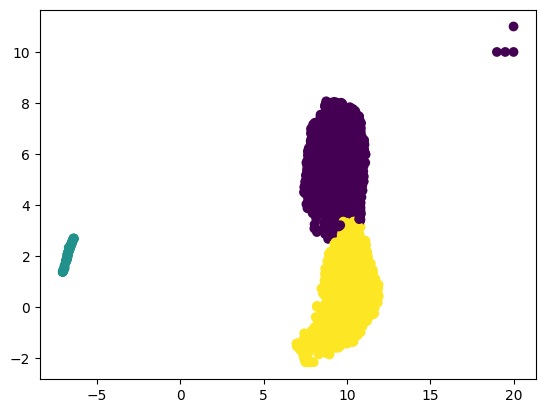

In [68]:
k = 2
import sklearn

umap_data_modified = umap_data.copy()
addition = np.asarray([[20,10], [20,11], [19,10], [19.5,10]])
umap_data_modified = np.vstack((umap_data_modified, addition))

# predicted_labels = cluster.KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(umap_data)
predicted_labels = cluster.AgglomerativeClustering(n_clusters=k+1, metric='euclidean').fit_predict(umap_data_modified)
# predicted_labels = cluster.OPTICS(min_samples=10, metric='euclidean').fit_predict(umap_data)

print(f"predicted_labels counts: {pd.Series(predicted_labels.reshape(-1)).value_counts()}")

# ari = adjusted_rand_score(true_labels, predicted_labels)
# print(ari)

plt.scatter(umap_data_modified[:,0], umap_data_modified[:,1], c=predicted_labels)

predicted_labels counts: 2    1421
0    1310
1      75
Name: count, dtype: int64
0.6204756743181695


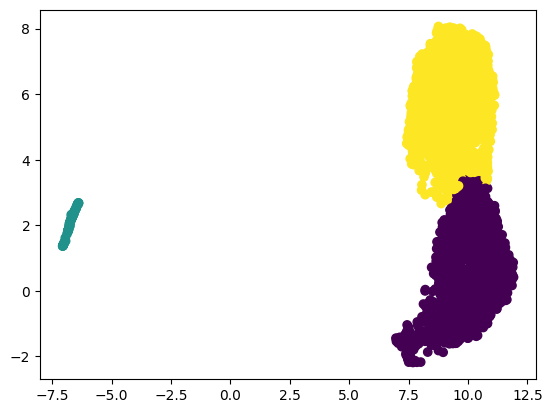

In [42]:
k = 3
# predicted_labels = cluster.KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(umap_data)
predicted_labels = cluster.AgglomerativeClustering(n_clusters=k).fit_predict(umap_data)

print(f"predicted_labels counts: {pd.Series(predicted_labels.reshape(-1)).value_counts()}")

ari = adjusted_rand_score(true_labels, predicted_labels)
print(ari)

plt.scatter(umap_data[:,0], umap_data[:,1], c=predicted_labels)

In [ ]:
k = 2

import numpy as np
from sklearn.cluster import DBSCAN
k = 2  # Replace with your actual k
coords = umap_data.copy()


# Step 1: Cluster with DBSCAN
# Note: Adjust eps and min_samples based on your data characteristics
# dbscan = DBSCAN(eps=0.5, min_samples=5)
# dbscan.fit(coords)
# labels = cluster.KMeans(n_clusters=10, n_init=10, random_state=42).fit_predict(coords)
# labels = dbscan.labels_

plt.scatter(coords[:,0], coords[:,1], c=labels)
plt.show()

# Step 2: Identify the largest k clusters
# Filter out the noise points (labelled as -1)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
unique_labels = set(labels) - {-1}

# Find the k largest clusters
cluster_sizes = [(cluster_label, sum(labels == cluster_label)) for cluster_label in unique_labels]
largest_clusters = sorted(cluster_sizes, key=lambda x: x[1], reverse=True)[:k]
largest_cluster_labels = [cluster[0] for cluster in largest_clusters]

# Step 3: Reassign labels
# Assign new labels: 0, 1, ..., k-1 to largest clusters, -1 to others
new_labels = np.full(labels.shape, -1)  # Initialize all as -1
for new_label, old_label in enumerate(largest_cluster_labels):
    new_labels[labels == old_label] = new_label

predicted_labels = new_labels
# print(f"predicted_labels counts: {pd.Series(predicted_labels.reshape(-1)).value_counts()}")

ari = adjusted_rand_score(true_labels, predicted_labels)
print(ari)

plt.scatter(umap_data[:,0], umap_data[:,1], c=predicted_labels)

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


import numpy as np
from sklearn.cluster import KMeans

import numpy as np
from sklearn.cluster import KMeans

# def iterative_kmeans(data, k, min_samples):
#     # Initialize labels with -1 (indicating dropped points)
#     final_labels = -1 * np.ones(data.shape[0], dtype=int)
    
#     # Initialize temporary data with the original data
#     temp_data = data.copy()
#     temp_indices = np.arange(data.shape[0])  # To track indices of original data

#     while True:
#         # Apply KMeans with k+1 clusters
#         kmeans = KMeans(n_clusters=k+1, random_state=0)
#         kmeans.fit(temp_data)
#         labels = kmeans.labels_

#         # Count points in each cluster
#         unique_labels, counts = np.unique(labels, return_counts=True)
#         print(counts)
#         # Find the smallest cluster
#         smallest_cluster = unique_labels[np.argmin(counts)]

#         # Check if the smallest cluster is below min_samples
#         if counts[np.argmin(counts)] < min_samples:
#             print("HERE")
#             # Drop points in the smallest cluster
#             keep_mask = labels != smallest_cluster
#             temp_data = temp_data[keep_mask]
#             temp_indices = temp_indices[keep_mask]

#             # Break the loop if we've dropped all points
#             if len(temp_data) == 0:
#                 break
            
#             plt.scatter(temp_data[:,0], temp_data[:,1], c=labels)
#             plt.show()
#         else:
#             # Assign final labels to the remaining data
#             final_labels[temp_indices] = labels
#             print("FINAL")
#             break

#     return final_labels


def iterative_kmeans(data, k, min_samples, max_k):
    best_labels = -1 * np.ones(data.shape[0], dtype=int)
    min_dropped_points = np.inf
    min_dif = np.inf

    for num_clusters in range(k+max_k, k-1,-1):
        # Initialize temporary data
        temp_data = data.copy()
        temp_indices = np.arange(data.shape[0])
        temp_labels = -1 * np.ones(data.shape[0], dtype=int)

        while True:
            # Apply KMeans
            kmeans = KMeans(n_clusters=num_clusters, random_state=0)
            kmeans.fit(temp_data)
            labels = kmeans.labels_

            plt.title(f"num_clusters: {num_clusters}, len(temp_data): {len(temp_data)}")
            plt.scatter(temp_data[:,0], temp_data[:,1], c=labels)
            plt.show()
            
            # Count points in each cluster
            unique_labels, counts = np.unique(labels, return_counts=True)

            # Find the smallest cluster
            smallest_cluster = unique_labels[np.argmin(counts)]
            print(counts)
            # Check if the smallest cluster is below min_samples
            if counts[np.argmin(counts)] < min_samples:
                # Drop points in the smallest cluster
                keep_mask = labels != smallest_cluster
                temp_data = temp_data[keep_mask]
                temp_indices = temp_indices[keep_mask]

                # Break the loop if we've dropped all points
                if len(temp_data) == 0:
                    break
            else:
                # Assign final labels to the remaining data
                temp_labels[temp_indices] = labels
                break

        # Check if this result is better (fewer points dropped)
        # dropped_points = np.sum(temp_labels == -1)
        # if dropped_points < min_dropped_points:
        #     min_dropped_points = dropped_points
        #     best_labels = temp_labels

        dif = abs(len(np.unique(temp_labels)) - k)
        if dif < min_dif:
            min_dif = dif
            best_labels = temp_labels

        # Break if we've found a solution with no points dropped
        if min_dropped_points == 0:
            break

    return best_labels


# Example usage
data = umap_data.copy()  # Replace with your actual data
addition = np.asarray([[30,10], [30,11], [30,10], [30.5,10]])
data = np.vstack((data, addition))
k = 2  # Desired number of clusters
min_samples = 100  # Minimum samples per cluster
max_k = 5 # Maximum additional clusters

predicted_labels = iterative_kmeans(data, k, min_samples, max_k)
print(pd.Series(predicted_labels).value_counts())

# ari = adjusted_rand_score(true_labels, predicted_labels)
# print(ari)

plt.title(f"ARI = {ari} (k={k}, min_samples={min_samples})")
plt.scatter(data[:,0], data[:,1], c=predicted_labels)

0    1512
1    1294
Name: count, dtype: int64
0.6462732265360271


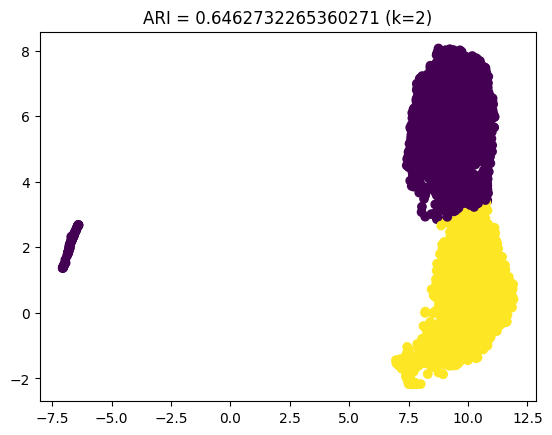

In [20]:
# #k-means-contrainsed

# import numpy as np
# from k_means_constrained import KMeansConstrained

# def cluster_without_outliers(X, k, outliers_fraction=0.1, random_state=42):
#     size_min = int(len(umap_data)*outliers_fraction)
    
#     clf = KMeansConstrained(
#             n_clusters=k,
#             size_min=size_min,
#             random_state=random_state
#         )
#     predicted_labels = clf.fit_predict(X)
#     return predicted_labels
    

# X = umap_data.copy()
# # addition = np.asarray([[30,10], [30,11], [30,10], [30.5,10]])
# # X = np.vstack((X, addition))
# k=2
# outliers_frac=0.1

# predicted_labels = cluster_without_outliers(X, k, outliers_frac)

# print(pd.Series(predicted_labels).value_counts())

# ari = adjusted_rand_score(true_labels, predicted_labels)
# print(ari)

# plt.title(f"ARI = {ari} (k={k})")
# plt.scatter(X[:,0], X[:,1], c=predicted_labels)

In [37]:
k = 2
kmeans_labels = cluster.KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(data_all_dims)
print(f"kmeans_labels counts: {pd.Series(kmeans_labels.reshape(-1)).value_counts()}")

ari = adjusted_rand_score(true_labels_all_dims, kmeans_labels)
print(ari)

kmeans_labels counts: 0    2730
1      76
Name: count, dtype: int64
-0.0016255412636605744


In [26]:
k = 3
kmeans_labels = cluster.KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(data_all_dims)
print(f"kmeans_labels counts: {pd.Series(kmeans_labels.reshape(-1)).value_counts()}")

ari = adjusted_rand_score(true_labels_all_dims, kmeans_labels)
print(ari)

kmeans_labels counts: 0    1415
1    1315
2      76
Name: count, dtype: int64
0.5323040827670041


-----------

# TESTING KMeansConstraint

In [2]:
import os
import sys



os.environ["MOMAPS_HOME"] = "/home/labs/hornsteinlab/Collaboration/MOmaps"
sys.path.insert(1, os.getenv("MOMAPS_HOME"))
print(f"MOMAPS_HOME: {os.getenv('MOMAPS_HOME')}")

import numpy as np
import pandas as pd
import logging
import  torch
import datetime

from src.common.lib.utils import get_if_exists, load_config_file
from src.common.lib.model import Model

from src.common.lib.metrics import cluster_without_outliers

import matplotlib.pyplot as plt

%matplotlib inline

%reload_ext autoreload
%autoreload 2
%aimport
%matplotlib inline


    

MOMAPS_HOME: /home/labs/hornsteinlab/Collaboration/MOmaps
Modules to reload:
all-except-skipped

Modules to skip:



In [62]:
def plot_clustering(X, y, outliers_fraction):
    k = len(y.unique())
    kmeans_labels = cluster_without_outliers(X, n_clusters=k, outliers_fraction=outliers_fraction, n_init=10, random_state=42)
    
    fig, ax = plt.subplots(1,2, figsize=(15,5.5))
    
    ax[0].set_title("Clustering")
    ax[0].scatter(X[:,0], X[:,1], c=kmeans_labels)
    
    for yy in y.unique():
        indx = y[y==yy].index
        ax[1].set_title("True labels")
        ax[1].scatter(X[indx,0], X[indx,1])
    
    plt.show()
    
def plot_clustering_with_load(X_path, y_path, outliers_fraction=0.1):
    X = np.load(X_path)
    y = np.load(y_path, allow_pickle=True)

    y = pd.Series(y.reshape(-1,))

    print(X.shape, y.shape)    

    plot_clustering(X,y,outliers_fraction)

(1688, 2) (1688,)


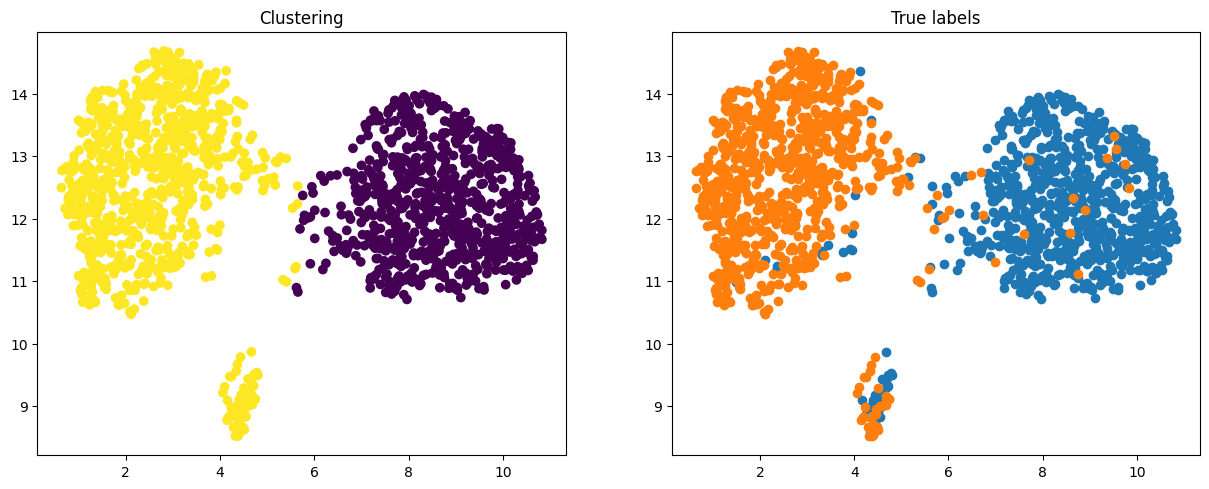

In [24]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig1/C/neuroself/UMAPs/110124_155849_470556_model_31/batch6_G3BP1_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig1/C/neuroself/UMAPs/110124_155849_470556_model_31/batch6_G3BP1_y.npy"

plot_clustering_with_load(X_path, y_path)

(905, 2) (905,)


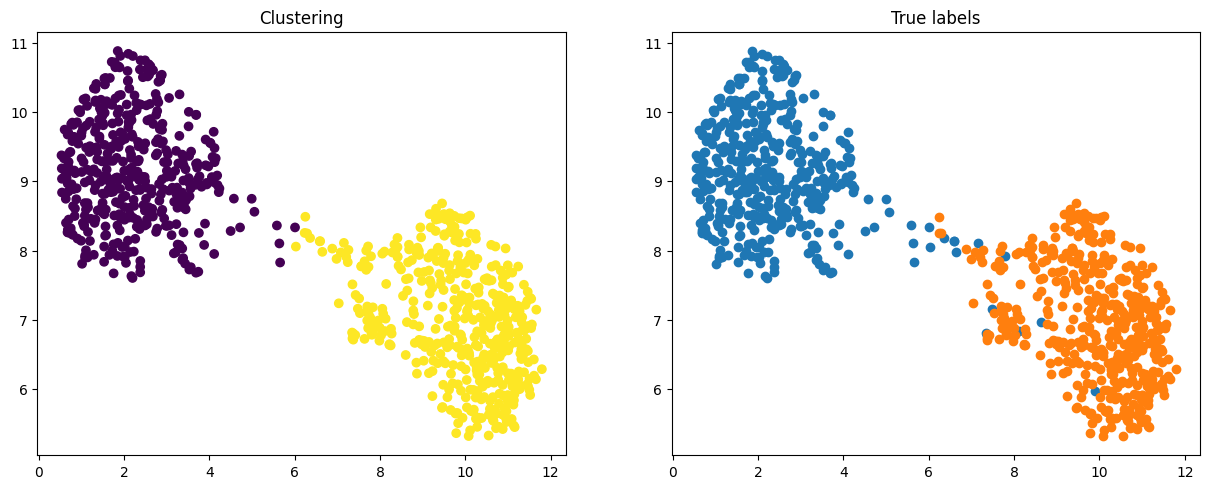

In [25]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig1/A/UMAPs/110124_155852_570462_model_33/U2OS_spd_format_G3BP1_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig1/A/UMAPs/110124_155852_570462_model_33/U2OS_spd_format_G3BP1_y.npy"

plot_clustering_with_load(X_path, y_path)

(1688, 2) (1688,)


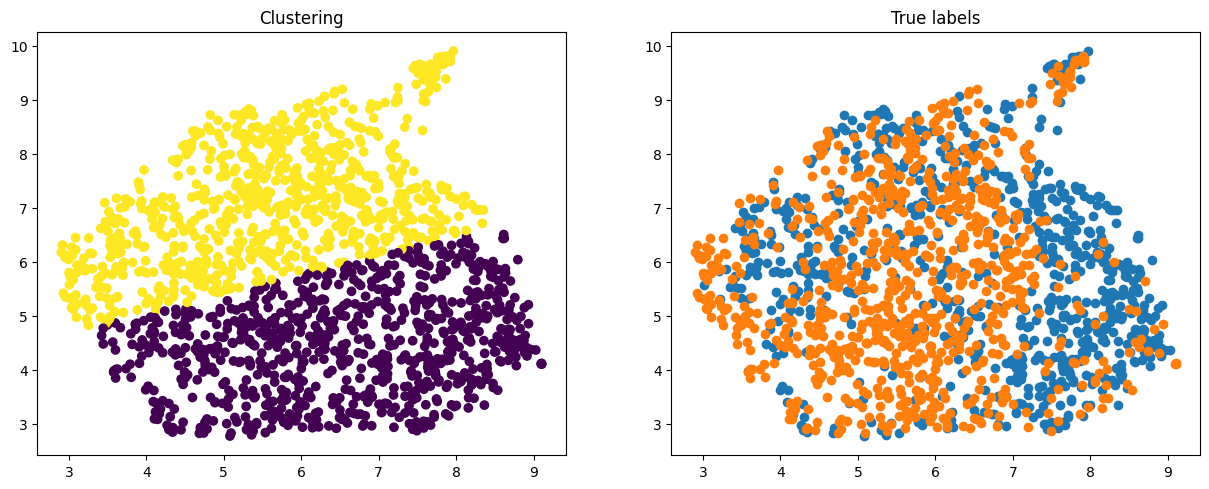

In [26]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig1/C/cyto/UMAPs/110124_155852_564421_model_33/batch6_G3BP1_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig1/C/cyto/UMAPs/110124_155852_564421_model_33/batch6_G3BP1_y.npy"

plot_clustering_with_load(X_path, y_path)

(1596, 2) (1596,)


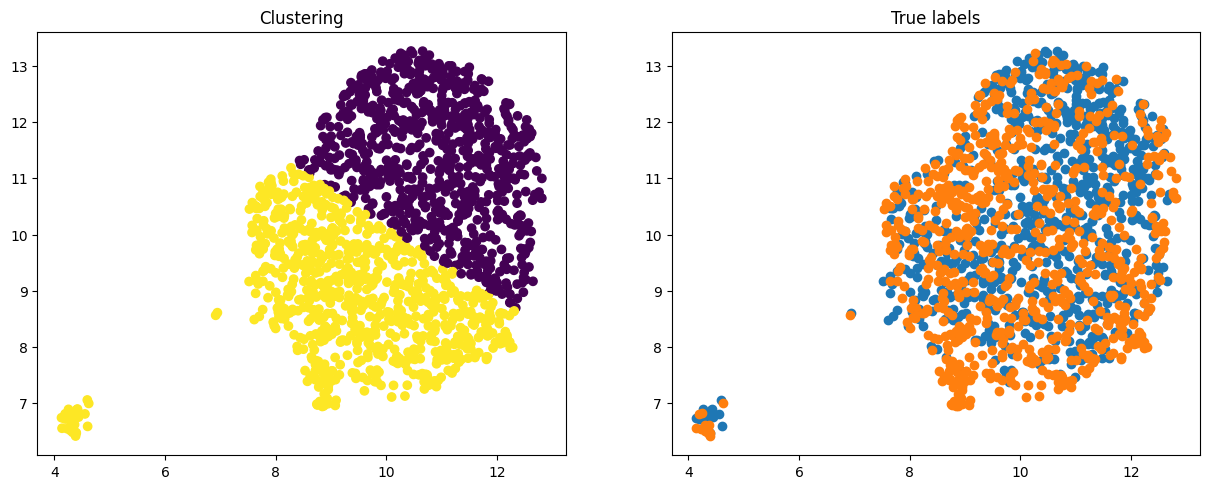

In [27]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig3/A/UMAPs/110124_160256_626220_model_31/batch6_ANXA11_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig3/A/UMAPs/110124_160256_626220_model_31/batch6_ANXA11_y.npy"

plot_clustering_with_load(X_path, y_path)

(17093, 2) (17093,)


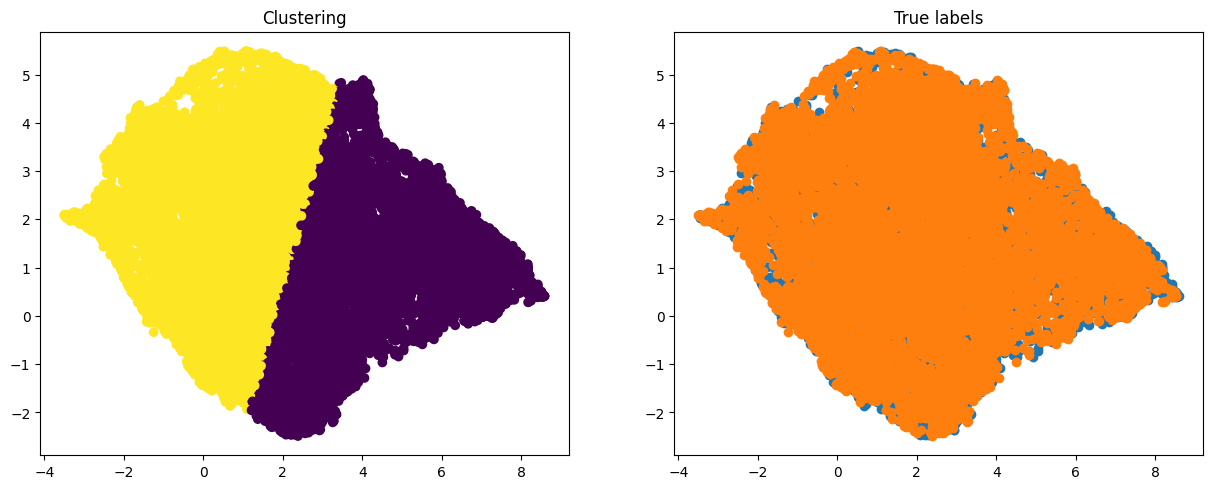

In [28]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig3/A/UMAPs/110124_160256_626220_model_31/batch6_DAPI_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig3/A/UMAPs/110124_160256_626220_model_31/batch6_DAPI_y.npy"

plot_clustering_with_load(X_path, y_path)

(1927, 2) (1927,)


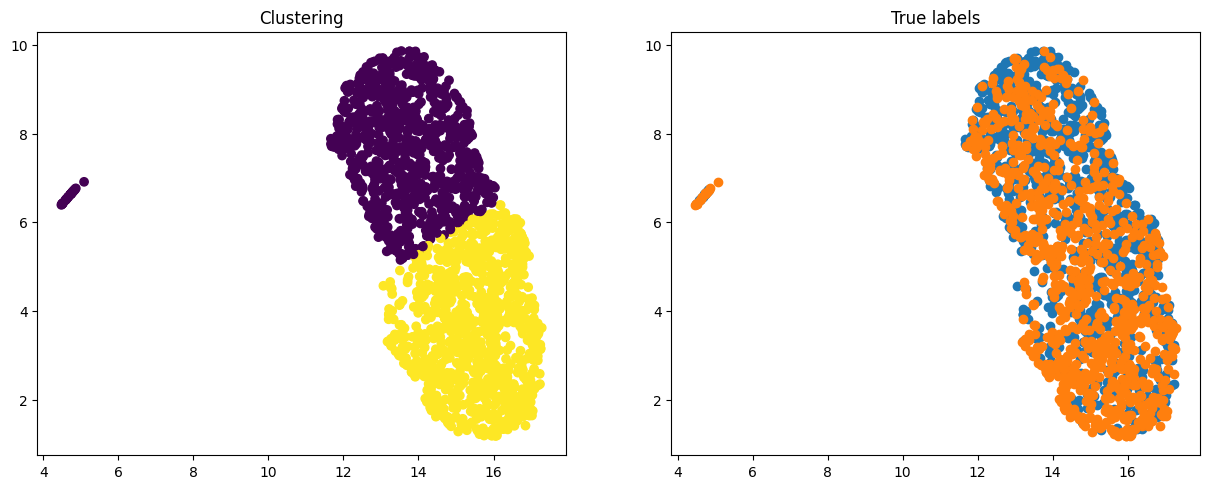

In [29]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig3/A/UMAPs/110124_160256_626220_model_31/batch6_FUS_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig3/A/UMAPs/110124_160256_626220_model_31/batch6_FUS_y.npy"

plot_clustering_with_load(X_path, y_path)

(1666, 2) (1666,)


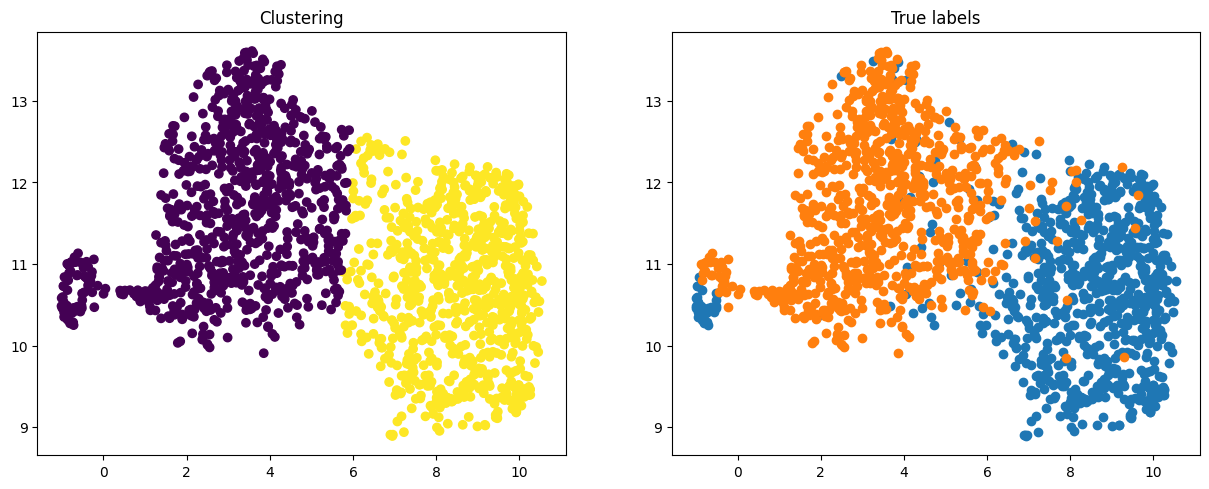

In [30]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig3/A/UMAPs/110124_160256_626220_model_31/batch6_PURA_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig3/A/UMAPs/110124_160256_626220_model_31/batch6_PURA_y.npy"

plot_clustering_with_load(X_path, y_path)

(1457, 2) (1457,)


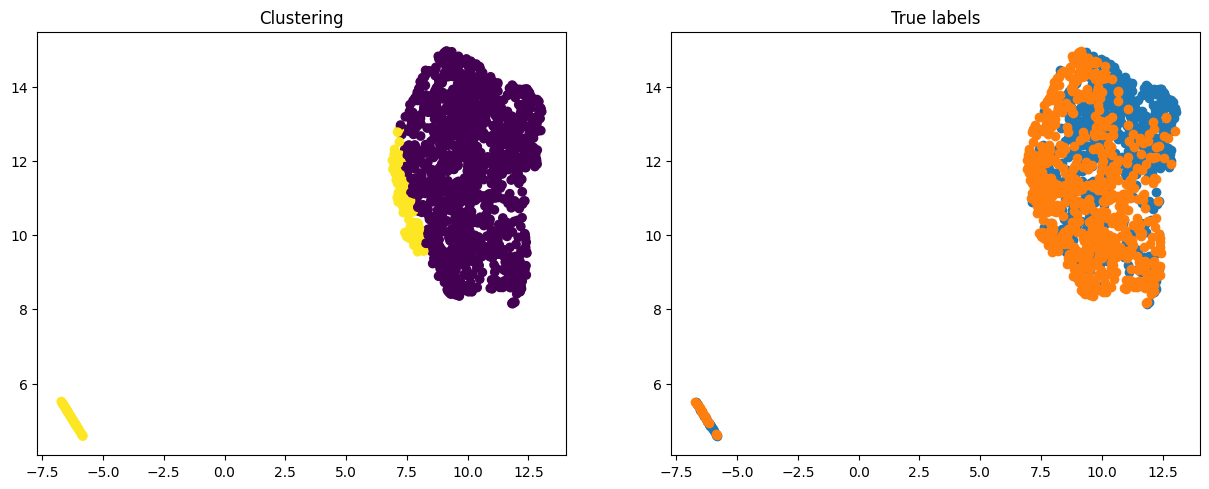

In [31]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig3/A/UMAPs/110124_160256_626220_model_31/batch6_SQSTM1_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig3/A/UMAPs/110124_160256_626220_model_31/batch6_SQSTM1_y.npy"

plot_clustering_with_load(X_path, y_path)

(7865, 2) (7865,)


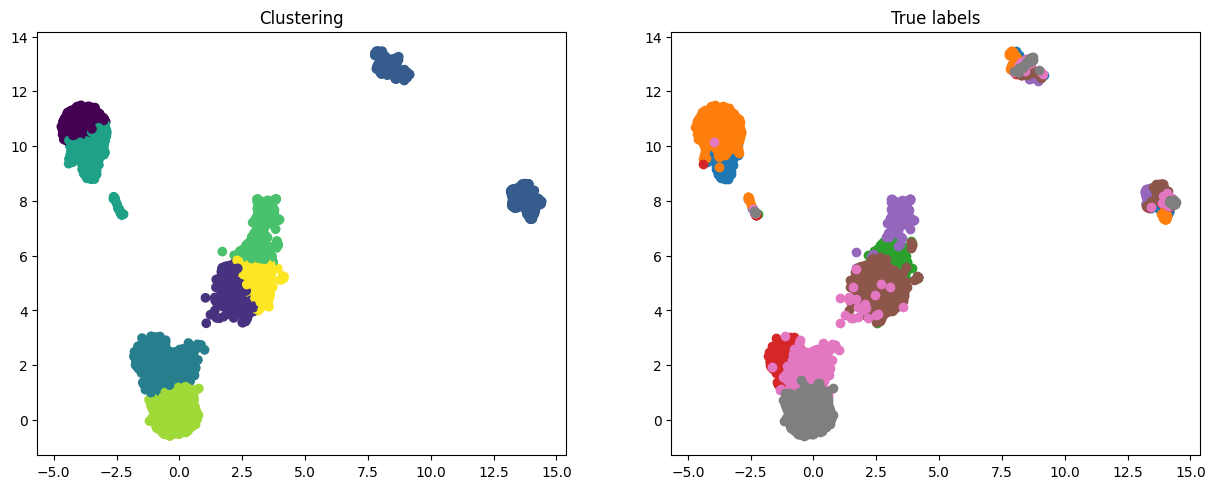

In [32]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig5/F/scna/b9/SM_UMAPs/110124_160506_796982_989518_model_31/batch9_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig5/F/scna/b9/SM_UMAPs/110124_160506_796982_989518_model_31/batch9_y.npy"

plot_clustering_with_load(X_path, y_path)

(7865, 2) (7865,)
size_min = 786


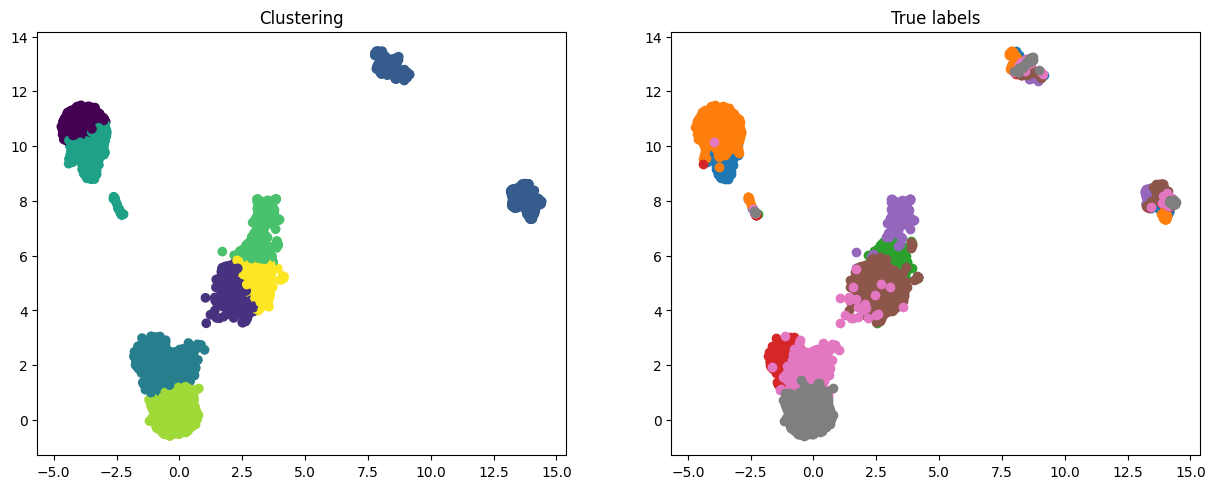

In [54]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig5/F/scna/b9/SM_UMAPs/110124_160506_796982_989518_model_31/batch9_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig5/F/scna/b9/SM_UMAPs/110124_160506_796982_989518_model_31/batch9_y.npy"

plot_clustering_with_load(X_path, y_path)


(7865, 2) (7865,)
size_min = 786


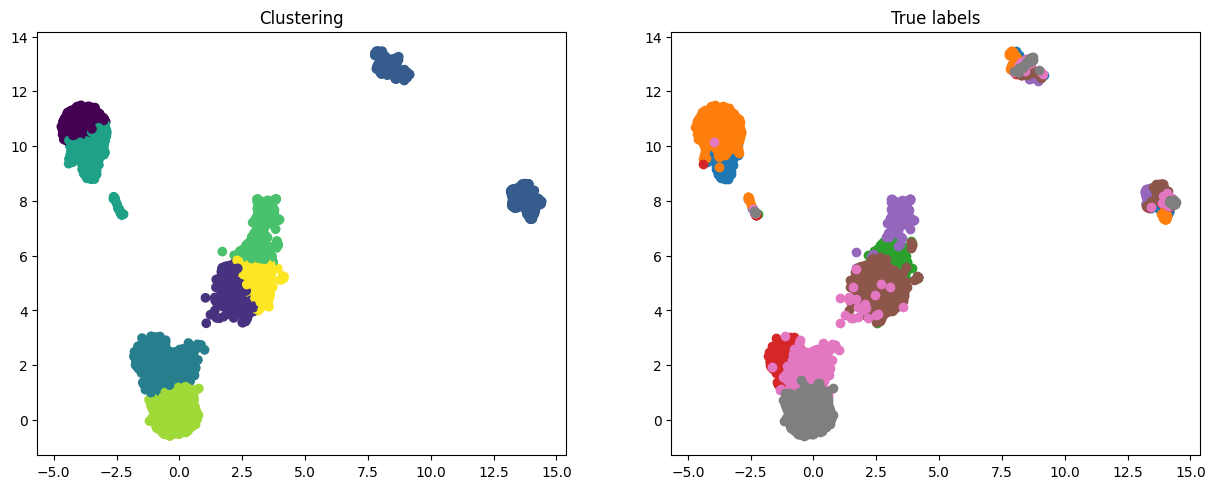

In [57]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig5/F/scna/b9/SM_UMAPs/110124_160506_796982_989518_model_31/batch9_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig5/F/scna/b9/SM_UMAPs/110124_160506_796982_989518_model_31/batch9_y.npy"

plot_clustering_with_load(X_path, y_path)

(4809, 2) (4809,)
size_min = 480


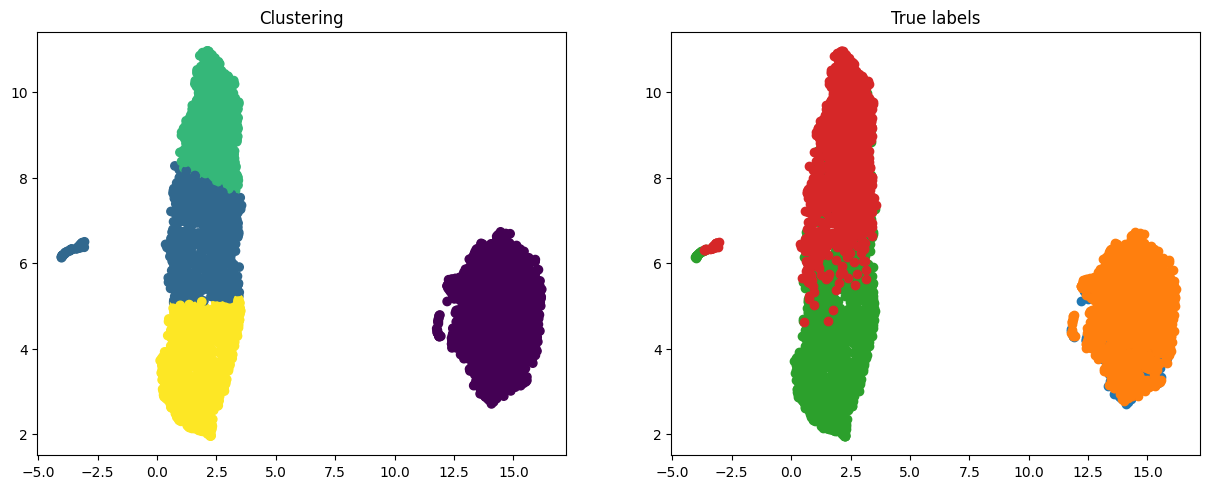

In [58]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig5/D/b9/UMAPs/110124_160311_491112_model_31/batch9_FUS_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig5/D/b9/UMAPs/110124_160311_491112_model_31/batch9_FUS_y.npy"

plot_clustering_with_load(X_path, y_path)

(1530, 2) (1530,)
size_min = 153


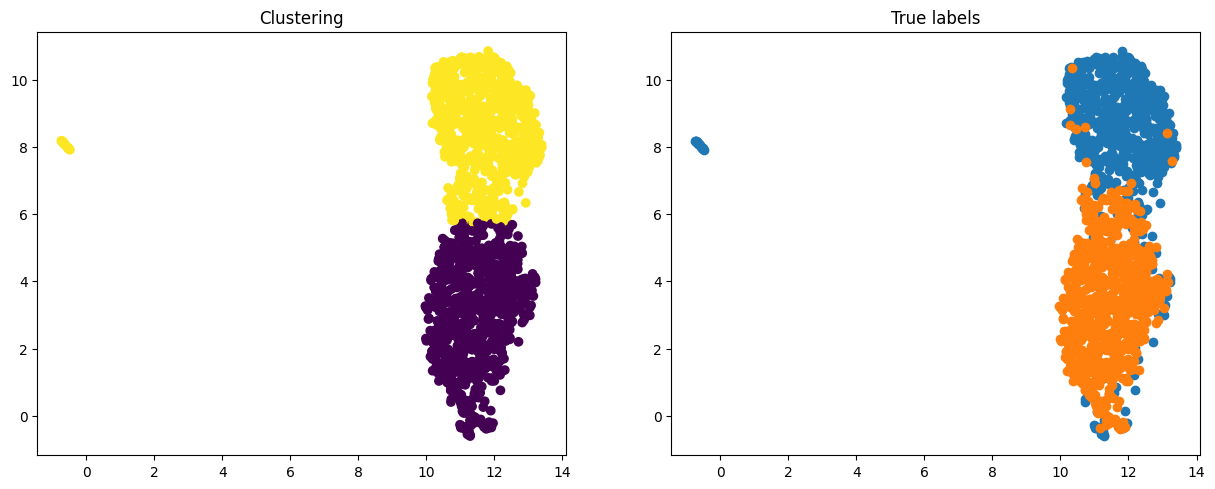

In [59]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/sup_fig4/A/UMAPs/110124_160519_346974_model_31/batch9_PURA_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/sup_fig4/A/UMAPs/110124_160519_346974_model_31/batch9_PURA_y.npy"

plot_clustering_with_load(X_path, y_path)

(7310, 2) (7310,)
size_min = 731


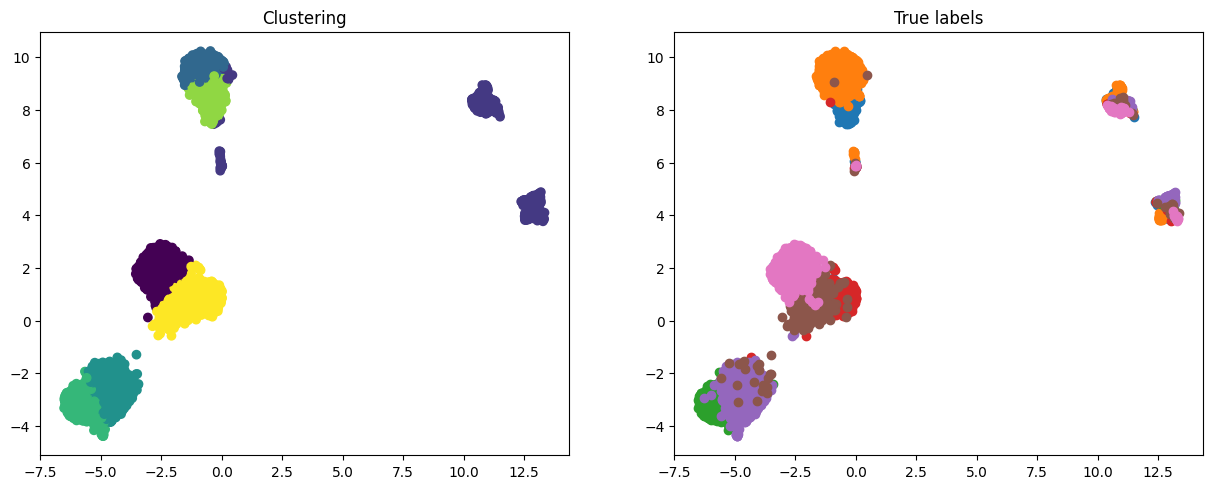

In [60]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/sup_fig6/A/SM_UMAPs/110124_160517_956079_989524_model_31/batch9_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/sup_fig6/A/SM_UMAPs/110124_160517_956079_989524_model_31/batch9_y.npy"

plot_clustering_with_load(X_path, y_path)

-- UMAP1 --

(14902, 2) (14902,)
size_min = 149


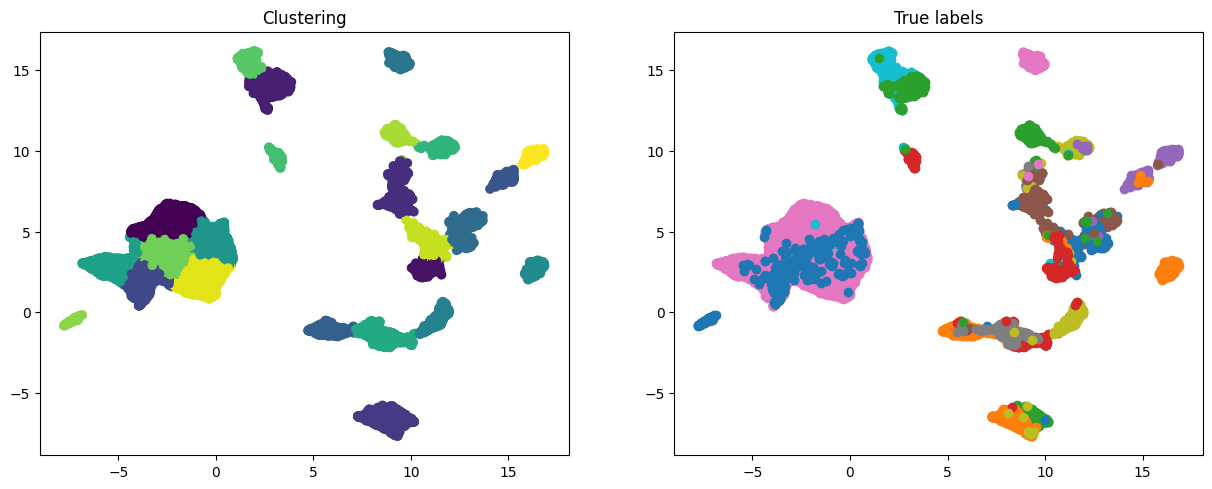

In [63]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig2/B/UMAPs/UMAP1110124_172705_369132_model_31/batch7_batch8_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig2/B/UMAPs/UMAP1110124_172705_369132_model_31/batch7_batch8_y.npy"

plot_clustering_with_load(X_path, y_path, 0.01)

(14902, 2) (14902,)
size_min = 596


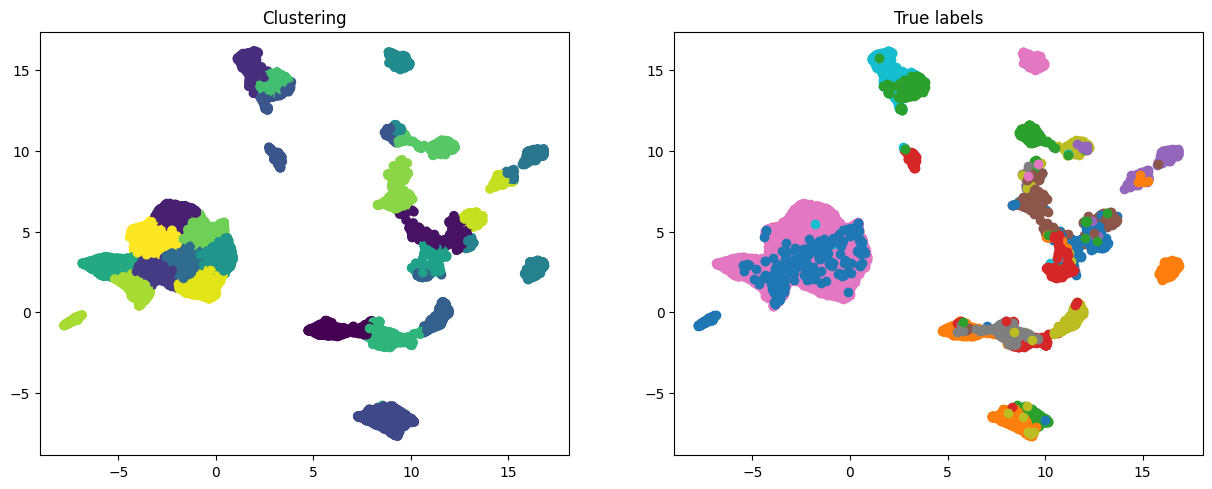

In [65]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig2/B/UMAPs/UMAP1110124_172705_369132_model_31/batch7_batch8_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig2/B/UMAPs/UMAP1110124_172705_369132_model_31/batch7_batch8_y.npy"

plot_clustering_with_load(X_path, y_path, 0.04)

(1812, 2) (1812,)
size_min = 181


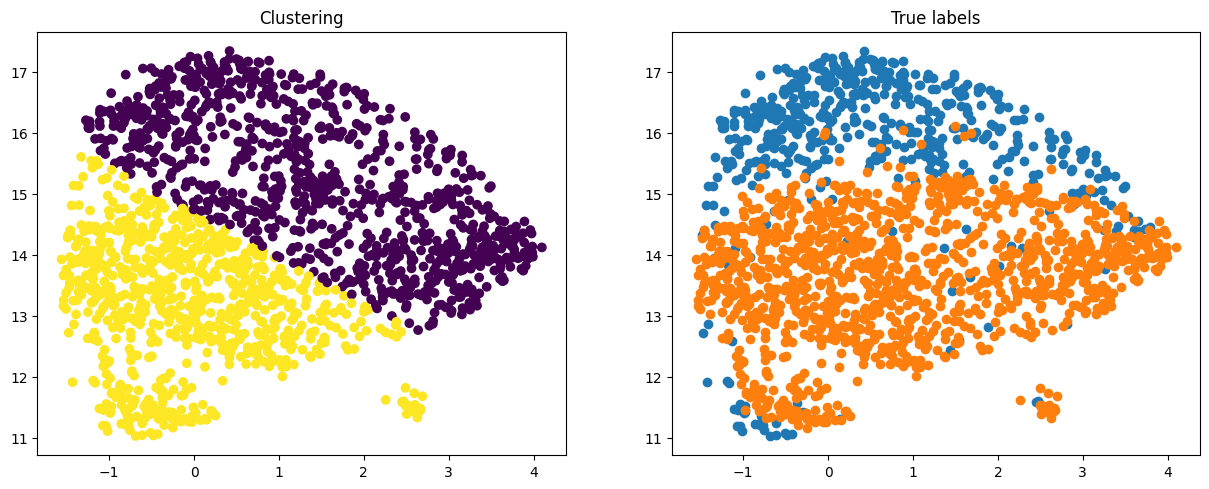

In [66]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/sup_fig6/D/SM_UMAPs/110124_190759_119210_993929_model_22/batch3_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/sup_fig6/D/SM_UMAPs/110124_190759_119210_993929_model_22/batch3_y.npy"

plot_clustering_with_load(X_path, y_path)

(1578, 2) (1578,)
size_min = 157


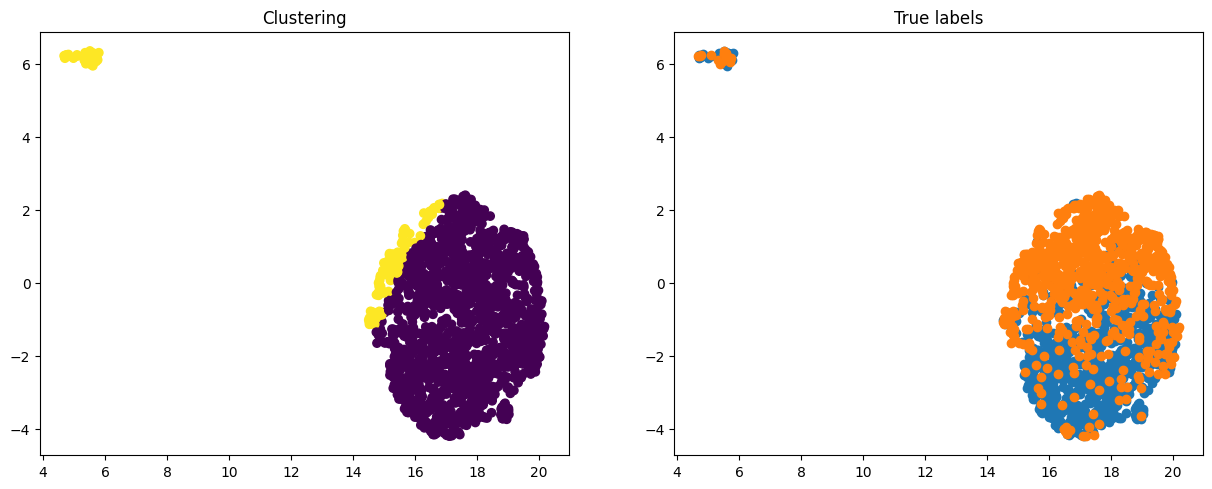

In [67]:
X_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig3/A/UMAPs/110124_160256_626220_model_31/batch6_TDP43_X.npy"
y_path = "/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/figures/tmp_sagy/110124/fig3/A/UMAPs/110124_160256_626220_model_31/batch6_TDP43_y.npy"

plot_clustering_with_load(X_path, y_path)